In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [15]:
def show_image(fname, path='../99_image/', size=(20,20)):
    """读取*.png图片并显示"""
    plt.figure(figsize=size)
    plt.imshow(plt.imread(path+fname))
    plt.axis('off')
    plt.show()

In [16]:
def show_describe(data):
    """输出数据的基本信息"""
    _mean = 0.0 if data.mean() < 1e-11 else  data.mean()
    _std = data.std()
    _min = data.min()
    _max = data.max()
    _norm_1 = np.linalg.norm(data, ord=1)
    _norm_2 = np.linalg.norm(data, ord=2)
    if 1-_norm_2 < 1e-11: _norm_2 = 1.0
    print('mean={0}, std={1},'.format(_mean, _std,))
    print('min={0}, max={1},'.format(_min, _max,))
    print('l1_norm={0}, l2_norm={1}'.format(_norm_1, _norm_2))    

# 特征选择的原因

进行特征选择有两个很重要的原因：

* 避免维数灾难：能剔除不相关(irrelevant)或冗余(redundant )的特征，从而达到减少特征个数，提高模型精确度，减少运行时间的目的

* 降低学习任务的难度：选取出真正相关的特征简化模型，协助理解数据产生的过程


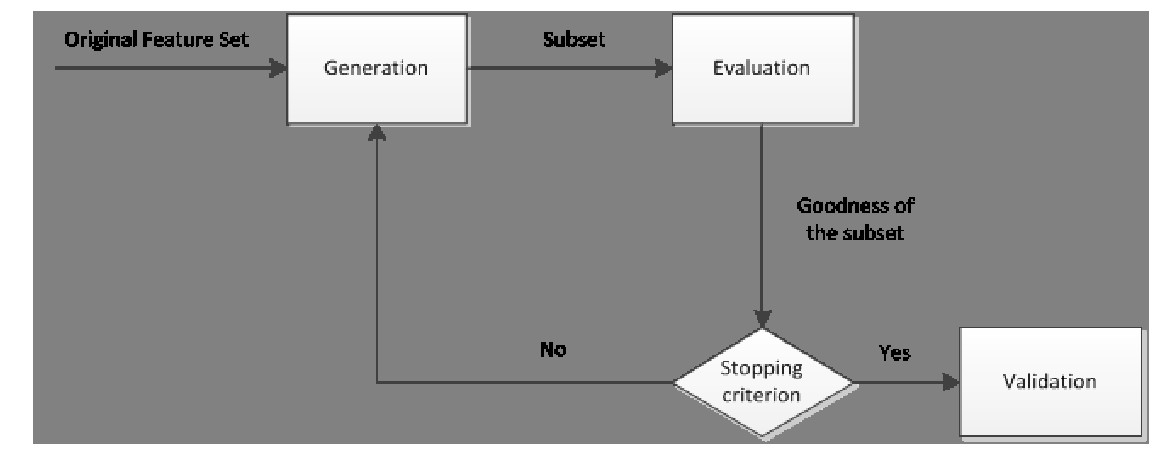

In [17]:
show_image('ml_feature_selection_frame.png')

如流程图所示，特征选择包括两个环节：

* 子集搜索 （subset search）

* 子集评价 （subset evaluation）

《机器学习》将特征选择分为了三种方法：分别是过滤式（filter） 、包裹式（wrapper）和嵌入式（embedded）。下面依据sklearn中的特征选择文档来叙述特征选择的几个方法。

In [18]:
from sklearn.datasets import load_iris
#导入IRIS数据集
iris = load_iris()
#特征矩阵
print(iris.data[:5])
#目标向量
print(iris.target[:5])
#特征名称
print(iris.feature_names)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [20]:
iris_number = pd.DataFrame(iris.data, 
                           columns=iris.feature_names, )

## 4.1 过滤式 (filter)
这类方法先对数据机进行特征选择，然后再训练学习器，特征选择的过程与后续学习器无关。   
它是先设计一个过滤方法进行特征选择，再去训练学习器。而这个过滤方式是设计一个“相关统计量”，去对特征进行计算，最后设定一个阈值去进行选择。

相关统计量计算：

对于每个样本xi，他都会做以下事情。

找出同类中，最邻近的样本x1；在异类中，找出最邻近的x2。

如果xi与x1更近，说明特征是对同类异类有益的，会增大相对应的统计量；反之，如果xi与x2更近，说明特征起到副作用，会减少相对应的统计量。（当然有时候也不需要把整个训练集全用上，可以用采样的办法进行计算）

### 4.1.1移除低方差的特征
方差小->变化小->近似常变量->信息少->区分度低

`VarianceThreshold` 是特征选择的一个简单基本方法，它会移除所有那些方差不满足阈值的特征。默认情况下，它将会移除所有的零方差特征，即那些在所有的样本上的取值均不变的特征。
例如，假设我们有一个特征是布尔值的数据集，我们想要移除那些在整个数据集中特征值为0或者为1的比例超过80%的特征。布尔特征是伯努利（ Bernoulli ）随机变量，变量的方差为$Var[X]=p(1−p)$

因此，我们可以使用阈值`方差`进行选择

In [17]:
from sklearn.feature_selection import VarianceThreshold
X = np.array([[0, 0, 1], 
              [0, 1, 0], 
              [1, 0, 0], 
              [0, 1, 1], 
              [0, 1, 0], 
              [0, 1, 1]])

X.std(axis=0)**2

array([0.13888889, 0.22222222, 0.25      ])

In [13]:
sel = VarianceThreshold(threshold=0.2)
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

### 4.1.2 单变量特征选择
单变量的特征选择是通过基于**单变量**的**统计测试分数**来选择最好的特征。它可以当做是评估器的预处理步骤。   
Scikit-learn 将特征选择的内容作为实现了 transform 方法的对象：

* SelectKBest : 选择分数最高的k个特征
* SelectPercentile : 选择分数最高的百分比特征
* GenericUnivariateSelect 允许使用可配置方法来进行单变量特征选择。它允许超参数搜索评估器来选择最好的单变量特征。

缺点:没有考虑到特征之间的关联作用,可能把有用的关联特征误踢掉

这种权重主要分析**特征与target的相关性**，这样的分析是与这次学习所使用的模型无关的。   
与模型无关特征权重分析方法包括:    
* 皮尔森相关系数法法（相关性）
> 相关系数只对线性关系敏感,不太能发现非线性相关   
> 相关系数只对两个实数型随机变量有定义

* 卡方检验法（相关性）
> 非负特征与分类标签之间的$\chi^2$统计量

* 互信息/最大信息系数（相关性）
> 通常用于分类(y为离散值)

例如下面的实例，我们可以使用$\chi^2$卡方检验）检验样本集来选择最好的

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X, y = iris.data, iris.target

In [20]:
chi2(X,y)

(array([ 10.81782088,   3.59449902, 116.16984746,  67.24482759]),
 array([4.47651499e-03, 1.65754167e-01, 5.94344354e-26, 2.50017968e-15]))

In [21]:
X_new = SelectKBest(chi2, k=3).fit_transform(X, y)
X_new.shape

(150, 3)

In [22]:
print(X[0,:])
print(X_new[0,:])

[5.1 3.5 1.4 0.2]
[5.1 1.4 0.2]


In [98]:
from sklearn.feature_selection import SelectPercentile
from minepy import MINE
#由于MINE的设计不是函数式的,定义mic方法将其为函数式的,
# 直接输入全部 X,y
# mic的输入应当是一维矩阵
# 将 X 转置, 再用 for 函数对原来的行进行操作
# 返回一个二元组,二元组的第2项设置成固定的P值0.5
def mic(X,y):
    mics = []
    for x in X.T:
        mine = MINE()
        mine.compute_score(x,y)
        mics.append(mine.mic())
    return np.array(mics)

In [99]:
mic(X, y)

array([0.6421959 , 0.40150415, 0.91829583, 0.91829583])

In [103]:
mic(X.astype(np.str), y.astype(np.str))

array([0.6421959 , 0.40150415, 0.91829583, 0.91829583])

In [100]:
X_new = SelectPercentile(mic, percentile=80).fit_transform(X, y)
# 保留 80% 的信息
X_new.shape

(150, 3)

In [101]:
print(X[0,:])
print(X_new[0,:])

[5.1 3.5 1.4 0.2]
[5.1 1.4 0.2]


## 4.2 包裹型 (Wrapper)
它与过滤式不同，它会考虑后续的学习器。它会直接把最终将要使用学习期的性能作为特征子集的评价准则。


### 4.2.1 递归式特征消除 (RFE)

* 第一步：用所有特征跑一个模型,得到特征系数(如线性模型系数的coef)或特征重要性(如xgboost中的feature_importances)

* 第二步：根据特征的系数或特征重要性,每次删除最不重要的(5-10%)
的特征,观察模型性能变化,直至模型性能出现大的下滑或达到
特征数目

`sklearn.feature_selection.RFE(estimator,n_features_to_select=None,step=1,estimator_params=None,verbose=0)`

参数:

1. estimator:一个学习器（通常使用SVM和广义线性模型作为estimator）
2. n_features_to_select:指定要选出几个特征
3. step:指定每次迭代要剔除权重最小的几个特征, 大于等于1：指定每次迭代要剔除权重最小的特征的数量；在0.0~1.0：指定每次迭代要剔除权重最小的特征的比例
4. estimator_params:一个字典，用于设定estimator的参数

sklearn还提供了RFECV类，它是RFE的一个变体，它执行一个交叉验证来寻找最优的剩余特征数量，因此不需要指定保留多少个特征。原型为

`sklearn.feature_selection.RFECV(estimator,step=1,cv=None,scoring=None,estimator_params=None,verbose=0)`

In [110]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X, y)
rfe.ranking_
# 1 是选出来的, 其它是排好序的

array([3, 4, 2, 1])

看来 第二个特征 的确没有太大作用

## 4.3 嵌入式(embedded)
模型训练后有系数或特征重要性属性的学习器的模型可用。

* 基于L1正则的特征选择
> L1正则得到的系数可能是稀疏的,选择非0系数即可实现特征选择   
> Lasso、Logistic回归(L1正则)、SVM(L1正则)

* 基于树的特征选择
> 基于树的模型(CART、随机森林、GBDT等)可以计算特征的重要性,   
> 从而可以根据重要性只选择重要的特征子集

`sklearn.feature_selection.SelectFromModel(estimator, threshold=None, prefit=False, norm_order=1)`

`SelectFromModel` 是一个*meta-transformer（元转换器）*，它可以用来处理任何带有 `coef_ `或者 `feature_importances_` 属性的训练之后的评估器。 如果相关的`coef_` 或者 `feature_importances_ `属性值低于预先设置的**阈值**，这些特征将会被认为不重要并且移除掉。   
除了指定数值上的阈值之外，还可以通过给定字符串参数来使用内置的启发式方法找到一个合适的阈值。可以使用的启发式方法有 `mean` 、 `median` 以及使用`浮点数乘以这些（例如，0.1*mean）`

In [112]:
from sklearn.svm import LinearSVC #分类器
from sklearn.feature_selection import SelectFromModel #特征选择方式

lsvc = LinearSVC(C=0.01, penalty='l1', dual=False).fit(X, y) #L1正则
model = SelectFromModel(lsvc, prefit=True) #特征选择实例
X_new = model.transform(X) #特征选择

In [116]:
lsvc.coef_

array([[ 0.        ,  0.21680447, -0.28727617,  0.        ],
       [ 0.        , -0.09186784,  0.        ,  0.        ],
       [-0.0346407 , -0.17067086,  0.13464363,  0.        ]])

In [113]:
print(X[0,:])
print(X_new[0,:])

[5.1 3.5 1.4 0.2]
[5.1 3.5 1.4]


In [23]:
## Default XGBoost
from xgboost import XGBClassifier
model_XGB = XGBClassifier()

model_XGB.fit(X,y)
model_XGB.feature_importances_

array([0.17701453, 0.11228534, 0.41479525, 0.29590487], dtype=float32)

In [24]:
sorted(model_XGB.feature_importances_)

[0.11228534, 0.17701453, 0.29590487, 0.41479525]

In [26]:
#可以根据特征重要性进行特征选择
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
thresholds = sorted(model_XGB.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_XGB, threshold=thresh, prefit=True)
    select_X = selection.transform(X)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X, y)
    # eval model
    y_pred = selection_model.predict(select_X)
    predictions = y_pred.round()
    accuracy = accuracy_score(y, predictions)
    print("Thresh={0}, n={1}, Accuracy: {2}%".format(thresh, select_X.shape[1], accuracy*100.0))

Thresh=0.11228533834218979, n=4, Accuracy: 100.0%
Thresh=0.1770145297050476, n=3, Accuracy: 100.0%
Thresh=0.29590487480163574, n=2, Accuracy: 99.33333333333333%
Thresh=0.41479524970054626, n=1, Accuracy: 95.33333333333334%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i